In [93]:
cd(@__DIR__) #src
using Agents, Random
using Agents.DataFrames, Agents.Graphs
using Distributions: Poisson, DiscreteNonParametric
using DrWatson: @dict
using CairoMakie
CairoMakie.activate!() # hide
using InteractiveDynamics
using StatsBase

function  model_init()
    @agent Cell GridAgent{2} begin
        time_alive::Int  # Time the cell has been alive
        near_cells::Int # Number of cells in the neighborhood
    end

    seed = 0
    rng = MersenneTwister(seed)
    l=100
    n0=10
    space = GridSpace((l, l))
    properties=@dict()
    model = ABM(Cell, space;properties, rng) 

    for i in 1:n0
        add_agent!(model,0,0)
    end
    return model
end


function agent_step!(agent, model)
    agent.time_alive += 1
    agent.near_cells = length(ids_in_position(agent, model))
    reproduce!(agent, model)
    move!(agent, model)
    die!(agent, model)
end

function move!(agent, model)
    pos = agent.pos
    nearby = [x for x in nearby_positions(agent,model,1)]
    newpos = rand(model.rng, nearby)
    if length(ids_in_position(agent, model)) > 1
        m = sample(nearby)
        move_agent!(agent,m, model)
    end
end

function reproduce!(agent,model)
    pid = agent.pos
    if rand(model.rng) < 0.01/(length(ids_in_position(agent, model))^2)
        add_agent!(pid,model,0,0)
    end
end

function die!(agent, model)
    pos = agent.pos
    nearby = [x for x in nearby_positions(agent,model,1)]
    if rand(model.rng) < 0.01*(length(ids_in_position(agent, model))^2)
        kill_agent!(agent, model)
    end
end

model = model_init()
println(model)
to_collect = [(:time_alive, length)]
data, _ = run!(model, agent_step!, 1000; adata = to_collect)

AgentBasedModel with 10 agents of type Cell
 space: GridSpace with size (100, 100), metric=chebyshev, periodic=true
 scheduler: fastest
 properties: 


(1001×2 DataFrame
  Row │ step   length_time_alive 
      │ Int64  Int64             
──────┼──────────────────────────
    1 │     0                 10
    2 │     1                 11
    3 │     2                 11
    4 │     3                 11
    5 │     4                 11
    6 │     5                 11
    7 │     6                 12
    8 │     7                 12
  ⋮   │   ⋮            ⋮
  995 │   994                  5
  996 │   995                  5
  997 │   996                  5
  998 │   997                  5
  999 │   998                  5
 1000 │   999                  4
 1001 │  1000                  4
                 986 rows omitted, 0×0 DataFrame)

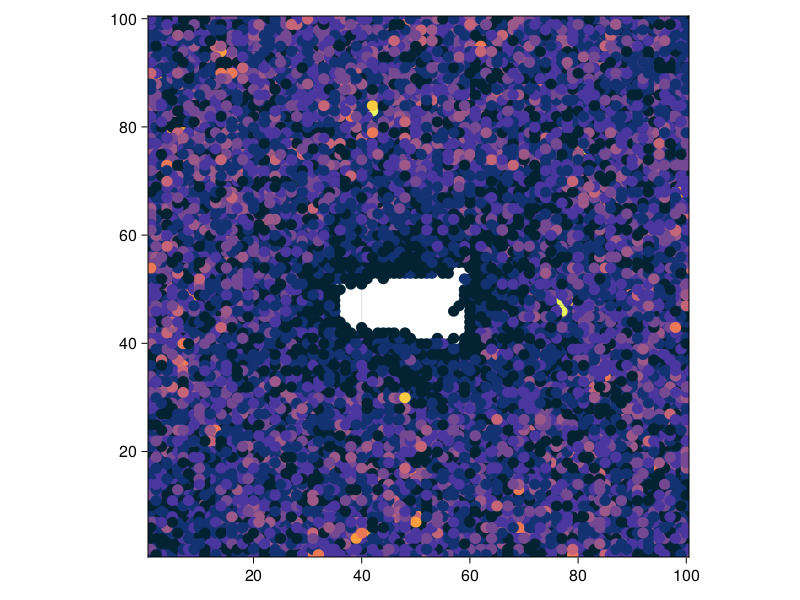

In [90]:
using ColorSchemes
colors=Dict(0=>:black,1=>:red,2=>:blue,3=>:green,4=>:yellow,5=>:orange,6=>:purple,7=>:pink,8=>:brown,9=>:cyan,10=>:gray)
densitycolor(a) = get(colorschemes[:thermal], a.near_cells, (1,10))

figure, _ = abmplot(model;ac = densitycolor)
figure # returning the figure displays it

In [91]:
model = model_init()
abmvideo(
    "schelling.mp4", model, agent_step!;
    framerate = 50, frames = 1000,ac = densitycolor,
    title = "Tumor growth"
)